In [14]:
## Breast Cancer LASSO Exploration
## Prepare workspace
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

X = loadmat("BreastCancer.mat")['X']
y = loadmat("BreastCancer.mat")['y']

##  10-fold CV 

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)
lam_vals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions

squaredErrorLasso = []
squaredErrorRidge = []
errorRateLasso = []
errorRateRidge = []
bestLambdasLasso = []
bestLambdasRidge = []
errorCountLasso = []
errorCountRidge = []

W_lasso = []
W_ridge = np.zeros((X.shape[1], len(lam_vals)))

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    print(len(v1_ind), len(v2_ind), len(trn_ind))
# Use training data to learn classifier
# W = ista_solve_hot(At,bt,lam_vals)

# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions
    W_lasso = ista_solve_hot(At, bt, lam_vals)
    
    for l in lam_vals:
        W_ridge[:, [i]] = At.T@np.linalg.inv(At@At.T + l*np.identity(At.shape[0]))@bt
    
    minErrorLasso, minErrorRidge = 1, 1
    minIndexLasso, minIndexRidge = None, None
    for i in range(len(lam_vals)):
        bv1_lasso = np.sign(Av1@W_lasso[:, [i]])
        bv1_ridge = np.sign(Av1@W_ridge[:, [i]])
        
        errorRateLasso1 = np.count_nonzero(bv1 - bv1_lasso) / bv1.shape[0]
        errorRateRidge1 = np.count_nonzero(bv1 - bv1_ridge) / bv1.shape[0]
        
        if errorRateLasso1 < minErrorLasso:
            minErrorLasso = errorRateLasso1
            minIndexLasso = i
            
            
        if errorRateRidge1 < minErrorRidge:
            minErrorRidge = errorRateRidge1
            minIndexRidge = i
        
        
    bv2_lasso = np.sign(Av2@W_lasso[:, [minIndexLasso]])
    bv2_ridge = np.sign(Av2@W_ridge[:, [minIndexRidge]])

    errorCountLasso.append(np.count_nonzero(bv2 - bv2_lasso)) 
    errorCountRidge.append(np.count_nonzero(bv2 - bv2_ridge)) 
    
    errorRateLasso2 = np.count_nonzero(bv2 - bv2_lasso) / bv2.shape[0]
    errorRateRidge2 = np.count_nonzero(bv2 - bv2_ridge) / bv2.shape[0]
    
    errorRateLasso.append(errorRateLasso2)
    errorRateRidge.append(errorRateRidge2)
    bestLambdasLasso.append(lam_vals[minIndexLasso])
    bestLambdasRidge.append(lam_vals[minIndexRidge])
    
    squaredErrorRidge.append(np.linalg.norm(bv2-bv2_ridge, 2)**2)
    squaredErrorLasso.append(np.linalg.norm(bv2-bv2_lasso, 2)**2)

print("Lasso average error rate: " + str(np.mean(errorRateLasso)))
print("Ridge average error rate: " + str(np.mean(errorRateRidge)))
print()

print("Lasso average lambda: " + str(np.mean(bestLambdasLasso)))
print("Ridge average lambda: " + str(np.mean(bestLambdasRidge)))
print()

print("Lasso average squarred error: " + str(np.mean(squaredErrorLasso)))
print("Ridge average squarred error: " + str(np.mean(squaredErrorRidge)))
print()

print("Lasso average misclassifications: " + str(np.mean(errorCountLasso)))
print("Ridge average misclassifications: " + str(np.mean(errorCountRidge)))

30 30 235
30 30 235
30 30 235
30 30 235
30 29 236
29 29 237
29 29 237
29 30 236
Lasso average error rate: 0.29137931034482756
Ridge average error rate: 0.29554597701149427

Lasso average lambda: 10.12500025
Ridge average lambda: 20.0

Lasso average squarred error: 34.5
Ridge average squarred error: 35.0

Lasso average misclassifications: 8.625
Ridge average misclassifications: 8.75


In [15]:
def ista_solve_hot( A, d, la_array ):
    # ista_solve_hot: Iterative soft-thresholding for multiple values of
    # lambda with hot start for each case - the converged value for the previous
    # value of lambda is used as an initial condition for the current lambda.
    # this function solves the minimization problem
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

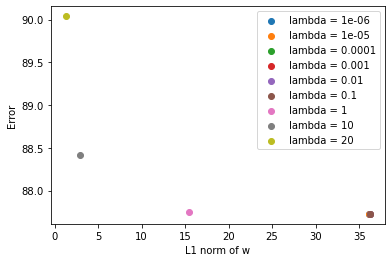

In [16]:
# a)

x_train = X[:100]
y_train = y[:100]

W = ista_solve_hot(x_train, y_train,lam_vals)

fig = plt.figure()
x_axis = fig.add_subplot(111)
for i in range(len(lam_vals)):
    w_l1 = np.linalg.norm(W[:,i],1)
    error = np.linalg.norm(x_train@W[:,i] - y_train, 2)
    x_axis.scatter(w_l1, error, label="lambda = {}".format(lam_vals[i]))
x_axis.set_xlabel('L1 norm of w')
x_axis.set_ylabel('Error')
plt.legend()
plt.show()

For initial values of of lambda, the l1 norm and the error are similar and as the l1 norm increases the error decreases. In adition as lamba increase, so does the error. The l1 norm and the error have an inverse relationship as seen in the graph.

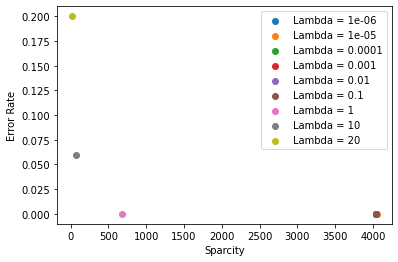

In [17]:
# b)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(len(lam_vals)):
    w = W[:,i]
    w = np.expand_dims(w, 1)
    errorRate = np.count_nonzero(np.sign(x_train@w) - y_train) / x_train.shape[0]
    sparcity = (w > 1e-6).sum()
    ax1.scatter(sparcity, errorRate, label="Lambda = {}".format(lam_vals[i]))
ax1.set_xlabel('Sparcity')
ax1.set_ylabel('Error Rate')
plt.legend()
plt.show()

As the spartity increases, the l1 norm increases and the error decreases. The l1 norm and the error have an inverse relationship as seen in the graph.

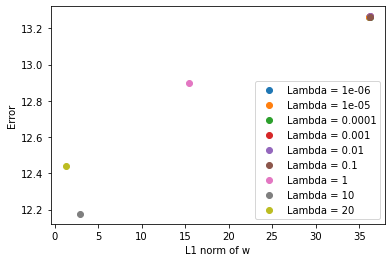

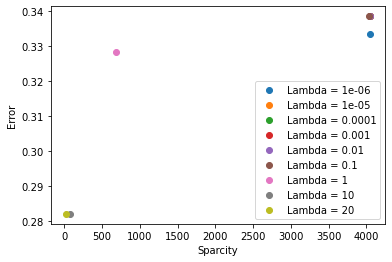

In [18]:
# c)

X_val = X[100:]
y_val = y[100:]

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(len(lam_vals)):
    w_l1 = np.linalg.norm(W[:,[i]], 1)
    error = np.linalg.norm(X_val@W[:,[i]] - y_val,2)
    ax1.scatter(w_l1, error, label="Lambda = {}".format(lam_vals[i]))
    

ax1.set_xlabel('L1 norm of w')
ax1.set_ylabel('Error')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(len(lam_vals)):
    w = W[:,i]
    w = np.expand_dims(w, 1)
    errorRate = np.count_nonzero(np.sign(X_val@w) - y_val) / X_val.shape[0]
    sparcity = (w > 1e-6).sum()

    ax1.scatter(sparcity, errorRate, label="Lambda = {}".format(lam_vals[i]))
ax1.set_xlabel('Sparcity')
ax1.set_ylabel('Error')
plt.legend()
plt.show()

The error rate decreases as lambda increases which might be caused by overfitting. 